In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns
import time

from nanonets import Simulation

plt.style.use(["science","bright","grid"])

In [38]:
# test  = Simulation(topo)
# ds    = np.arange(1,20)
# caps  = []
# caps1 = [test.mutual_capacitance_adjacent_spheres(2.6, 10, 10, 20*d) for d in ds]
# caps2 = [test.mutual_capacitance_adjacent_spheres(2.6, 10, 20, 30*d) for d in ds]

# plt.plot(caps1,'-o')
# # plt.plot(caps2,'-o')
# plt.xlabel("$n \cdot d$")
# plt.ylabel("$C_{ij}$")
# plt.savefig('cap_vs_d.svg')

In [39]:
def get_simulation_based_matrices(L):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*8}
    simc = Simulation(topo)
    c_mat = simc.get_capacitance_matrix()
    c_ele = simc.get_electrode_capacitance_matrix()
    return c_mat, c_ele

In [40]:
def get_net_topology(L):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*8}
    simc = Simulation(topo)
    return simc.get_net_topology()

In [ ]:
class FDMSolver:
    """
    A Finite Difference Method (FDM) solver for 3D electrostatic capacitance.
    """
    def __init__(self, resolution=1.0):

        # Grid Resolution in nm
        self.res = resolution
        
        # Default Material Properties (Relative Permittivity)
        self.props = {
            'air': 1.0,  
            'filler': 2.6, 
            'sio2': 3.9,
            'si': 11.7
        }
        
        # Grid state
        self.epsilon = None
        self.conductor_mask = None
        self.nx = 0
        self.ny = 0
        self.nz = 0
        self.grid_coords = None # (X, Y, Z)
        
        # Solver state
        self.A_free = None
        self.is_free = None
        self.solver_ready = False
        
        # Results
        self.conductors = {} # Map ID -> Name
        
    def initialize_grid(self, width_nm, height_nm, z_start):
        """
        Creates the 3D voxel grid based on physical dimensions.
        """
        print(f"[Grid] Initializing {width_nm}x{width_nm}x{height_nm} nm volume...")

        self.nx = int(np.ceil(width_nm / self.res))
        self.ny = int(np.ceil(width_nm / self.res))
        self.nz = int(np.ceil(height_nm / self.res))
        
        total_nodes = self.nx * self.ny * self.nz
        print(f"[Grid] Nodes: {self.nx}x{self.ny}x{self.nz} ({total_nodes/1e6:.2f} Million)")
        
        # 1. Material Arrays
        self.epsilon = np.ones((self.nx, self.ny, self.nz), dtype=np.float32) * self.props['air']
        self.conductor_mask = np.zeros((self.nx, self.ny, self.nz), dtype=np.int16)
        
        # 2. Coordinate Mesh (for geometry definition)
        x = np.linspace(-width_nm/2, width_nm/2, self.nx)
        y = np.linspace(-width_nm/2, width_nm/2, self.ny)
        z = np.linspace(z_start, z_start + height_nm, self.nz)
        self.grid_coords = np.meshgrid(x, y, z, indexing='ij')

    def add_substrate_stack(self, sio2_thick, encapsulated=False):
        """
        Defines the Silicon / SiO2 / Filler stack.
        """
        X, Y, Z = self.grid_coords
        
        # Silicon Substrate (Bottom)
        self.epsilon[Z < -sio2_thick] = self.props['si']
        
        # SiO2 Layer (-thick to 0)
        self.epsilon[(Z >= -sio2_thick) & (Z < 0)] = self.props['sio2']
        
        # Filler (Between spheres)
        if encapsulated:
            self.epsilon[Z >= 0] = self.props['filler']
        else:
            # Underfill assumption (approx 20nm height)
            self.epsilon[(Z >= 0) & (Z <= 20.0)] = self.props['filler']

    def add_sphere_lattice(self, L, radius, gap):
        """
        Adds an LxL lattice of spheres.
        Order: Row-by-Row, starting from Bottom-Left (y=min, x=min) and ending at Top-Right (y=max, x=max).
        """
        pitch = 2 * radius + gap
        # Center the grid around (0,0)
        offset = (L - 1) * pitch / 2
        
        X, Y, Z = self.grid_coords
        sphere_ids = []
        
        # Counter starts at 1
        count = 0
        
        print(f"[Geometry] Adding {L}x{L} Sphere Lattice (Bottom-Left -> Top-Right)...")
        
        # OUTER LOOP: Y (Rows from Bottom to Top)
        for j in range(L): 
            # INNER LOOP: X (Cols from Left to Right)
            for i in range(L):
                count += 1
                c_id = count # Sphere ID 1..9
                
                # Calculate physical coordinates
                cx = i * pitch - offset
                cy = j * pitch - offset
                cz = radius
                
                # Create Sphere Mask
                dist_sq = (X - cx)**2 + (Y - cy)**2 + (Z - cz)**2
                mask = dist_sq <= radius**2
                
                self.conductor_mask[mask] = c_id
                self.epsilon[mask] = 1000.0 # High permittivity for conductor internal
                
                # Store name for debugging
                self.conductors[c_id] = f"Sphere_{c_id}_Pos({i},{j})"
                sphere_ids.append(c_id)
                
        return sphere_ids

    def add_surrounding_electrodes(self, lattice_span, margin, elec_dist, elec_size):
        """
        Adds 8 electrodes in the specific user-defined order.
        Returns the list of IDs [101, 102, ... 108] corresponding to:
        1:Bot, 2:BL, 3:BR, 4:L, 5:R, 6:TL, 7:TR, 8:Top
        """
        print("[Geometry] Adding 8 Electrodes in Custom Order...")
        X, Y, Z = self.grid_coords
        
        width_nm = lattice_span + 2 * margin
        limit = width_nm / 2
        
        # Physical Positions
        # lattice_span is center-to-center. 
        # Edge of lattice is at +/- (lattice_span/2 + radius).
        # We simplify: assume lattice_span includes the radius extent roughly for placement
        phys_edge = (lattice_span / 2) + 10.0 # + radius
        pos = phys_edge + elec_dist + elec_size/2
        
        # Define the 8 positions in YOUR exact order
        # Format: (Name, X_center, Y_center)
        # We use IDs 101-108 to avoid conflict with spheres 1-99
        electrode_defs = [
            ("Bottom",       0,   -pos), # 1
            ("Bottom-Left", -pos, -pos), # 2
            ("Bottom-Right", pos, -pos), # 3
            ("Left",        -pos,  0),   # 4
            ("Right",        pos,  0),   # 5
            ("Top-Left",    -pos,  pos), # 6
            ("Top-Right",    pos,  pos), # 7
            ("Top",          0,    pos), # 8
        ]
        
        generated_ids = []
        
        for idx, (name, cx, cy) in enumerate(electrode_defs):
            e_id = 101 + idx # IDs 101 to 108
            
            # Create Block Logic
            half_s = elec_size / 2
            x_min, x_max = cx - half_s, cx + half_s
            y_min, y_max = cy - half_s, cy + half_s
            
            # Extend to infinity (Simulation Boundaries)
            # If the electrode center is "Left", extend x_min to -infinity (-limit)
            # If "Right", extend x_max to +infinity (+limit), etc.
            
            if cx < -1: x_min = -limit # Left-ish
            if cx >  1: x_max =  limit # Right-ish
            if cy < -1: y_min = -limit # Bottom-ish
            if cy >  1: y_max =  limit # Top-ish
            
            # Note on Corners: A corner like Bottom-Left (-pos, -pos) 
            # satisfies both (cx < -1) and (cy < -1), so it extends to 
            # BOTH the left edge and bottom edge, filling the corner. Correct.

            mask = (X >= x_min) & (X <= x_max) & \
                   (Y >= y_min) & (Y <= y_max) & \
                   (Z >= 0) & (Z <= 20.0) # Height 20nm
            
            self.conductor_mask[mask] = e_id
            self.epsilon[mask] = 1000.0
            
            self.conductors[e_id] = f"Elec_{idx+1}_{name}"
            generated_ids.append(e_id)
            
        return generated_ids

    def build_matrix(self):
        """
        Constructs the Sparse Laplacian Matrix.
        """
        print("[Solver] Building Matrix (this may take time)...")
        t0 = time.time()
        
        num_nodes = self.nx * self.ny * self.nz
        
        # Helper to flat index
        eps_flat = self.epsilon.flatten()
        cond_flat = self.conductor_mask.flatten()
        
        self.is_free = (cond_flat == 0)
        free_indices = np.arange(num_nodes)[self.is_free]
        
        # Storage for COO matrix
        entries_row = []
        entries_col = []
        entries_val = []
        diag_vals = np.zeros(num_nodes)
        
        # Neighbors (6-point stencil)
        neighbors = [(-1,0,0), (1,0,0), (0,-1,0), (0,1,0), (0,0,-1), (0,0,1)]
        
        # Pre-calculate coordinates to check bounds safely
        ix, iy, iz = np.unravel_index(free_indices, (self.nx, self.ny, self.nz))
        
        for dx, dy, dz in neighbors:
            # Neighbor coords
            n_ix, n_iy, n_iz = ix + dx, iy + dy, iz + dz
            
            # Valid Mask (Strict Boundary Check)
            valid = (n_ix >= 0) & (n_ix < self.nx) & \
                    (n_iy >= 0) & (n_iy < self.ny) & \
                    (n_iz >= 0) & (n_iz < self.nz)
            
            if not np.any(valid): continue

            # Indices
            valid_src = free_indices[valid]
            valid_tgt = np.ravel_multi_index(
                (n_ix[valid], n_iy[valid], n_iz[valid]), 
                (self.nx, self.ny, self.nz)
            )
            
            # Physics: Conductance
            eps_here = eps_flat[valid_src]
            eps_there = eps_flat[valid_tgt]
            cond = 2.0 * (eps_here * eps_there) / (eps_here + eps_there)
            
            # Fill Matrix
            entries_row.extend(valid_src)
            entries_col.extend(valid_tgt)
            entries_val.extend(-cond)
            
            np.add.at(diag_vals, valid_src, cond)
            
        # Add Diagonal
        entries_row.extend(free_indices)
        entries_col.extend(free_indices)
        entries_val.extend(diag_vals[free_indices])
        
        # Create Matrix
        self.A = sp.coo_matrix((entries_val, (entries_row, entries_col)), shape=(num_nodes, num_nodes))
        self.A = self.A.tocsr()
        self.A_free = self.A[self.is_free][:, self.is_free]
        
        print(f"[Solver] Matrix built in {time.time()-t0:.1f}s.")
        self.solver_ready = True

    def solve(self, active_ids, passive_ids):
        """
        Solves for the capacitance matrix.
        active_ids: List of IDs (Spheres) to stimulate with 1V.
        passive_ids: List of IDs (Electrodes) to measure induced charge on.
        """
        if not self.solver_ready:
            raise RuntimeError("Matrix not built. Call build_matrix() first.")
            
        n_active = len(active_ids)
        n_passive = len(passive_ids)
        
        # Result Matrices
        C_internal = np.zeros((n_active, n_active)) # Sphere-Sphere
        C_coupling = np.zeros((n_passive, n_active)) # Electrode-Sphere
        
        scale = 8.854e-12 * (self.res * 1e-9) # to Farads
        
        print(f"[Solver] Starting Iterative Solution for {n_active} spheres...")
        
        for idx, s_id in enumerate(active_ids):
            print(f"  -> Solving Sphere ID {s_id}...")
            
            # 1. Setup RHS
            b_vector = self._compute_rhs(s_id)
            
            # 2. Iterative Solve (CG)
            # Note: atol is optional but good for stability
            phi_free, info = spla.cg(self.A_free, b_vector, rtol=1e-5, atol=1e-8, maxiter=5000)
            
            if info > 0: print("WARNING: Solver did not converge.")
            
            # 3. Reconstruct Full Potential
            phi_full = np.zeros(self.nx * self.ny * self.nz)
            phi_full[self.is_free] = phi_free
            mask_active = (self.conductor_mask.flatten() == s_id)
            phi_full[mask_active] = 1.0
            
            # 4. Extract Charges
            # Internal (Sphere-Sphere)
            for row_idx, target_id in enumerate(active_ids):
                q = self._get_flux(phi_full, target_id)
                C_internal[row_idx, idx] = q * scale
            
            # Coupling (Electrode-Sphere)
            for row_idx, target_id in enumerate(passive_ids):
                q = self._get_flux(phi_full, target_id)
                C_coupling[row_idx, idx] = q * scale
                
        return C_internal, C_coupling

    def _compute_rhs(self, active_id):
        """Internal helper to build the Right-Hand Side vector."""
        num_nodes = self.nx * self.ny * self.nz
        rhs = np.zeros(num_nodes)
        cond_flat = self.conductor_mask.flatten()
        eps_flat = self.epsilon.flatten()
        
        # Active nodes (Fixed at 1V)
        active_nodes = np.where(cond_flat == active_id)[0]
        
        neighbors = [(-1,0,0), (1,0,0), (0,-1,0), (0,1,0), (0,0,-1), (0,0,1)]
        ix, iy, iz = np.unravel_index(active_nodes, (self.nx, self.ny, self.nz))
        
        for dx, dy, dz in neighbors:
            n_ix, n_iy, n_iz = ix + dx, iy + dy, iz + dz
            valid = (n_ix >= 0) & (n_ix < self.nx) & \
                    (n_iy >= 0) & (n_iy < self.ny) & \
                    (n_iz >= 0) & (n_iz < self.nz)
            
            if not np.any(valid): continue
            
            src = active_nodes[valid]
            tgt = np.ravel_multi_index((n_ix[valid], n_iy[valid], n_iz[valid]), (self.nx, self.ny, self.nz))
            
            # Only affect FREE nodes
            # If target is another conductor, it's fixed at 0V (Dirichlet), 
            # so it doesn't enter the linear system for unknowns.
            is_tgt_free = (cond_flat[tgt] == 0)
            
            valid_src = src[is_tgt_free]
            valid_tgt = tgt[is_tgt_free]
            
            eps_in = eps_flat[valid_src]
            eps_out = eps_flat[valid_tgt]
            cond = 2.0 * (eps_in * eps_out) / (eps_in + eps_out)
            
            np.add.at(rhs, valid_tgt, cond)
            
        return rhs[self.is_free]

    def _get_flux(self, phi, c_id):
        """Internal helper to integrate flux leaving conductor c_id."""
        cond_flat = self.conductor_mask.flatten()
        c_nodes = np.where(cond_flat == c_id)[0]
        eps_flat = self.epsilon.flatten()
        
        if len(c_nodes) == 0: return 0.0
        
        flux_sum = 0.0
        neighbors = [(-1,0,0), (1,0,0), (0,-1,0), (0,1,0), (0,0,-1), (0,0,1)]
        ix, iy, iz = np.unravel_index(c_nodes, (self.nx, self.ny, self.nz))
        
        for dx, dy, dz in neighbors:
            n_ix, n_iy, n_iz = ix + dx, iy + dy, iz + dz
            valid = (n_ix >= 0) & (n_ix < self.nx) & \
                    (n_iy >= 0) & (n_iy < self.ny) & \
                    (n_iz >= 0) & (n_iz < self.nz)
            
            if not np.any(valid): continue
            
            src = c_nodes[valid]
            tgt = np.ravel_multi_index((n_ix[valid], n_iy[valid], n_iz[valid]), (self.nx, self.ny, self.nz))
            
            # Only flux into free space matters for Gauss law
            # (Flux into another conductor cancels out in system, or handled by BCs)
            is_tgt_free = (cond_flat[tgt] == 0)
            
            valid_src = src[is_tgt_free]
            valid_tgt = tgt[is_tgt_free]
            
            v_nbr = phi[valid_tgt]
            
            # Determine V_self (Is this the active conductor?)
            # We can check phi at the source node. If it's the active one, it's 1.0.
            # If it's a passive grounded one, it's 0.0.
            v_self = phi[valid_src] 
            
            eps_in = eps_flat[valid_src]
            eps_out = eps_flat[valid_tgt]
            cond = 2.0 * (eps_in * eps_out) / (eps_in + eps_out)
            
            flux = cond * (v_self - v_nbr)
            flux_sum += np.sum(flux)
            
        return flux_sum

# ==========================================
# USAGE EXAMPLE
# ==========================================

if __name__ == "__main__":
    
    # 1. Configuration
    L = 6
    radius_nm = 10.0
    gap_nm = 1.0
    sio2_nm = 35.0
    
    # Calculate Dimensions
    pitch = 2 * radius_nm + gap_nm
    lattice_span = (L - 1) * pitch # Center-to-Center span
    
    # Margin for electrodes
    elec_size = 20.0
    elec_dist = 1.0
    margin = elec_dist + elec_size + 10.0
    
    width_total = lattice_span + 2 * (radius_nm + margin)
    height_total = sio2_nm + 50.0 # Substrate + Air
    
    # 2. Instantiate Solver
    # Increase resolution to 0.5 for high precision (slower)
    solver = FDMSolver(resolution=1.0) 
    
    # 3. Setup Geometry
    z_start = -(sio2_nm + 20)
    solver.initialize_grid(width_total, height_total, z_start)
    
    solver.add_substrate_stack(sio2_thick=sio2_nm, encapsulated=False)
    
    # Add Conductors
    sphere_ids = solver.add_sphere_lattice(L=L, radius=radius_nm, gap=gap_nm)
    
    # We pass the 'lattice_span' so electrodes are placed relative to the grid
    # solver.add_surrounding_electrodes(lattice_span, margin, elec_dist, elec_size)
        
    # Define which IDs are "Active" (Spheres) and "Passive" (Electrodes)
    electrode_ids = solver.add_surrounding_electrodes(lattice_span, margin, elec_dist, elec_size)

    # 4. Build & Solve
    solver.build_matrix()
    
    C_sph, C_elec = solver.solve(active_ids=sphere_ids, passive_ids=electrode_ids)
    
    # Output with Labels
    print("\n--- 8x9 Electrode Coupling Matrix (aF) ---")
    labels = ["1:Bot", "2:BL", "3:BR", "4:L", "5:R", "6:TL", "7:TR", "8:Top"]
    
    print(f"{'IDX':<8} {'Label':<10} | Spheres 1..9 (Bottom-Left -> Top-Right)")
    print("-" * 80)
    for i, row in enumerate(C_elec):
        # Convert row to string
        data_str = "  ".join([f"{val*1e18:6.1f}" for val in row])
        print(f"{i+1:<8} {labels[i]:<10} | {data_str}")

[Grid] Initializing 187.0x187.0x85.0 nm volume...
[Grid] Nodes: 187x187x85 (2.97 Million)
[Geometry] Adding 6x6 Sphere Lattice (Bottom-Left -> Top-Right)...
[Geometry] Adding 8 Electrodes in Custom Order...
[Solver] Building Matrix (this may take time)...
[Solver] Matrix built in 8.6s.
[Solver] Starting Iterative Solution for 36 spheres...
  -> Solving Sphere ID 1...
  -> Solving Sphere ID 2...
  -> Solving Sphere ID 3...
  -> Solving Sphere ID 4...
  -> Solving Sphere ID 5...
  -> Solving Sphere ID 6...
  -> Solving Sphere ID 7...
  -> Solving Sphere ID 8...
  -> Solving Sphere ID 9...
  -> Solving Sphere ID 10...
  -> Solving Sphere ID 11...
  -> Solving Sphere ID 12...
  -> Solving Sphere ID 13...
  -> Solving Sphere ID 14...
  -> Solving Sphere ID 15...
  -> Solving Sphere ID 16...
  -> Solving Sphere ID 17...
  -> Solving Sphere ID 18...
  -> Solving Sphere ID 19...
  -> Solving Sphere ID 20...
  -> Solving Sphere ID 21...
  -> Solving Sphere ID 22...
  -> Solving Sphere ID 23...


In [48]:
np.savetxt(fname=f'c_mat_L={L}.csv', X=C_sph*1e18)
np.savetxt(fname=f'c_ele_L={L}.csv', X=np.abs(C_elec)*1e18)

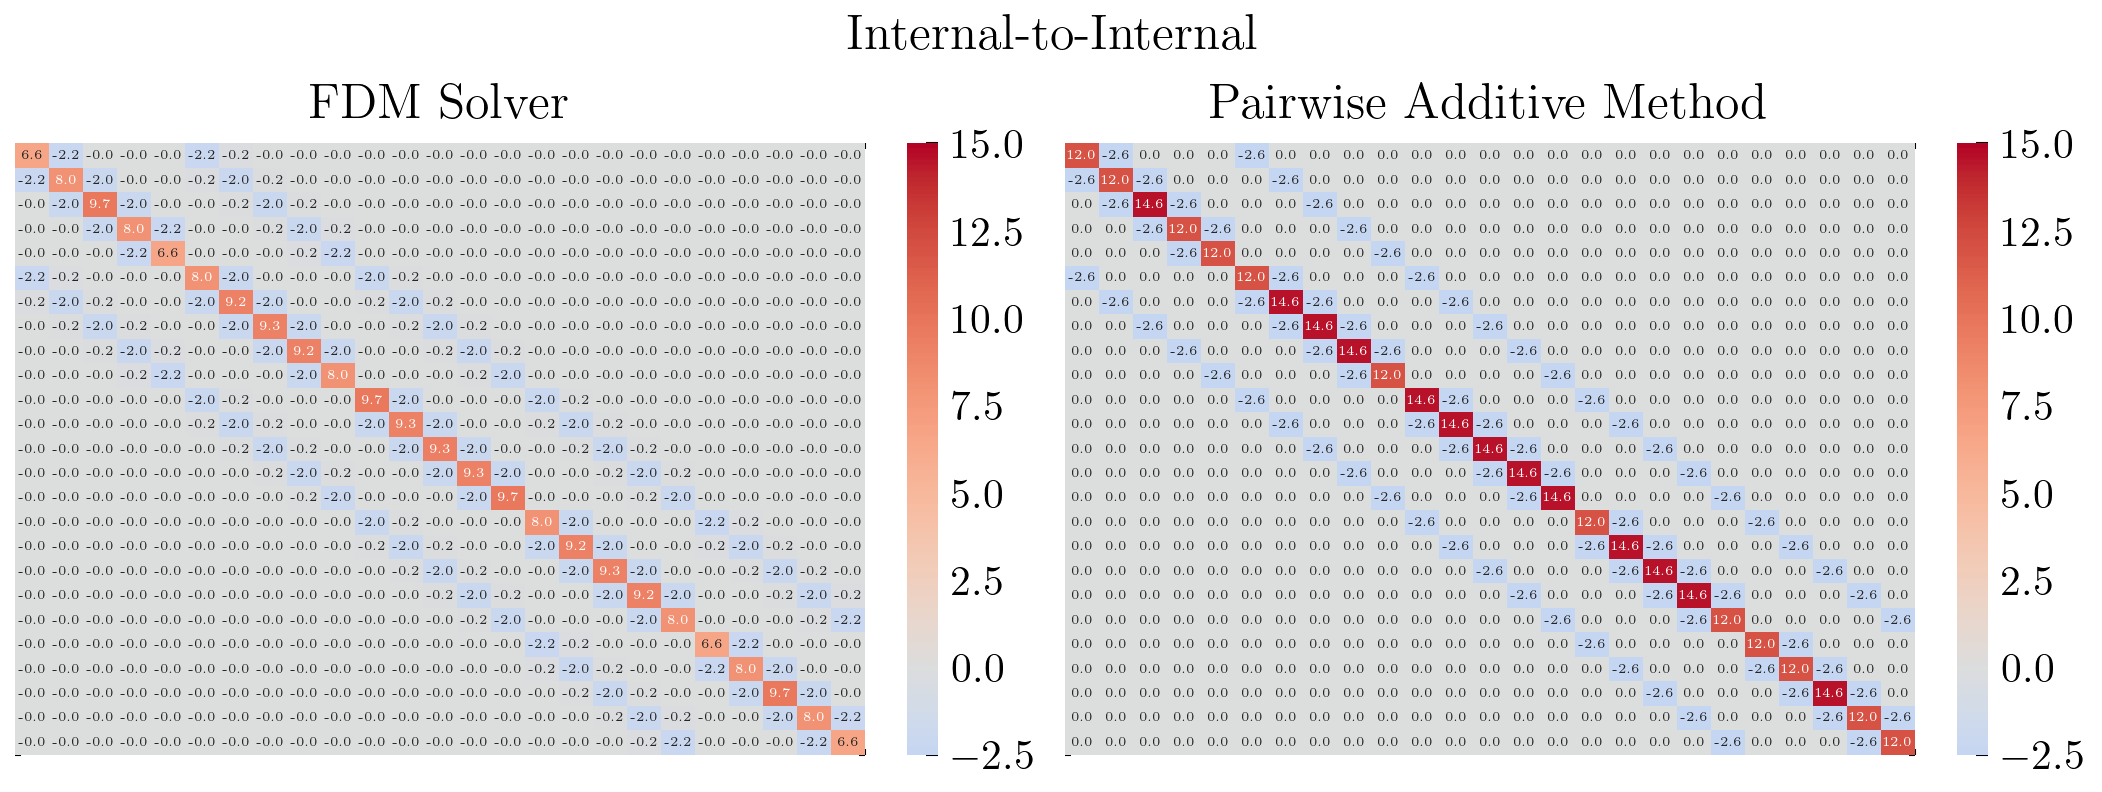

In [61]:
fig = plt.figure(dpi=300, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
fig.suptitle("Internal-to-Internal")
ax  = fig.add_subplot(1,2,1)
ax  = sns.heatmap(C_sph * 1e18, ax=ax, cmap='coolwarm', center=0, annot=True, fmt=".1f", vmin=-2.5, vmax=15, annot_kws={"size":3})#, vmin=-2.5, vmax=10)
_   = ax.set_title("FDM Solver")
_   = ax.set_xticklabels("")
_   = ax.set_yticklabels("")

ax  = fig.add_subplot(1,2,2)
ax  = sns.heatmap(get_simulation_based_matrices(5)[0], ax=ax, cmap='coolwarm', center=0, annot=True, fmt=".1f", vmin=-2.5, vmax=15, annot_kws={"size":3})#, vmin=-2.5, vmax=10)
_   = ax.set_title("Pairwise Additive Method")
_   = ax.set_xticklabels("")
_   = ax.set_yticklabels("")

In [90]:
def get_net_topology(L):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*8}
    simc = Simulation(topo)
    return simc.get_positions()

In [96]:
L = 3
topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*8}
simc = Simulation(topo)
simc.get_electrode_dist_matrix()

array([[29.69848481, 21.        , 29.69848481, 46.95742753, 42.        ,
        46.95742753, 66.40783086, 63.        , 66.40783086],
       [21.        , 42.        , 63.        , 29.69848481, 46.95742753,
        66.40783086, 46.95742753, 59.39696962, 75.71657678],
       [63.        , 42.        , 21.        , 66.40783086, 46.95742753,
        29.69848481, 75.71657678, 59.39696962, 46.95742753],
       [29.69848481, 46.95742753, 66.40783086, 21.        , 42.        ,
        63.        , 29.69848481, 46.95742753, 66.40783086],
       [66.40783086, 46.95742753, 29.69848481, 63.        , 42.        ,
        21.        , 66.40783086, 46.95742753, 29.69848481],
       [46.95742753, 59.39696962, 75.71657678, 29.69848481, 46.95742753,
        66.40783086, 21.        , 42.        , 63.        ],
       [75.71657678, 59.39696962, 46.95742753, 66.40783086, 46.95742753,
        29.69848481, 63.        , 42.        , 21.        ],
       [66.40783086, 63.        , 66.40783086, 46.95742753, 42

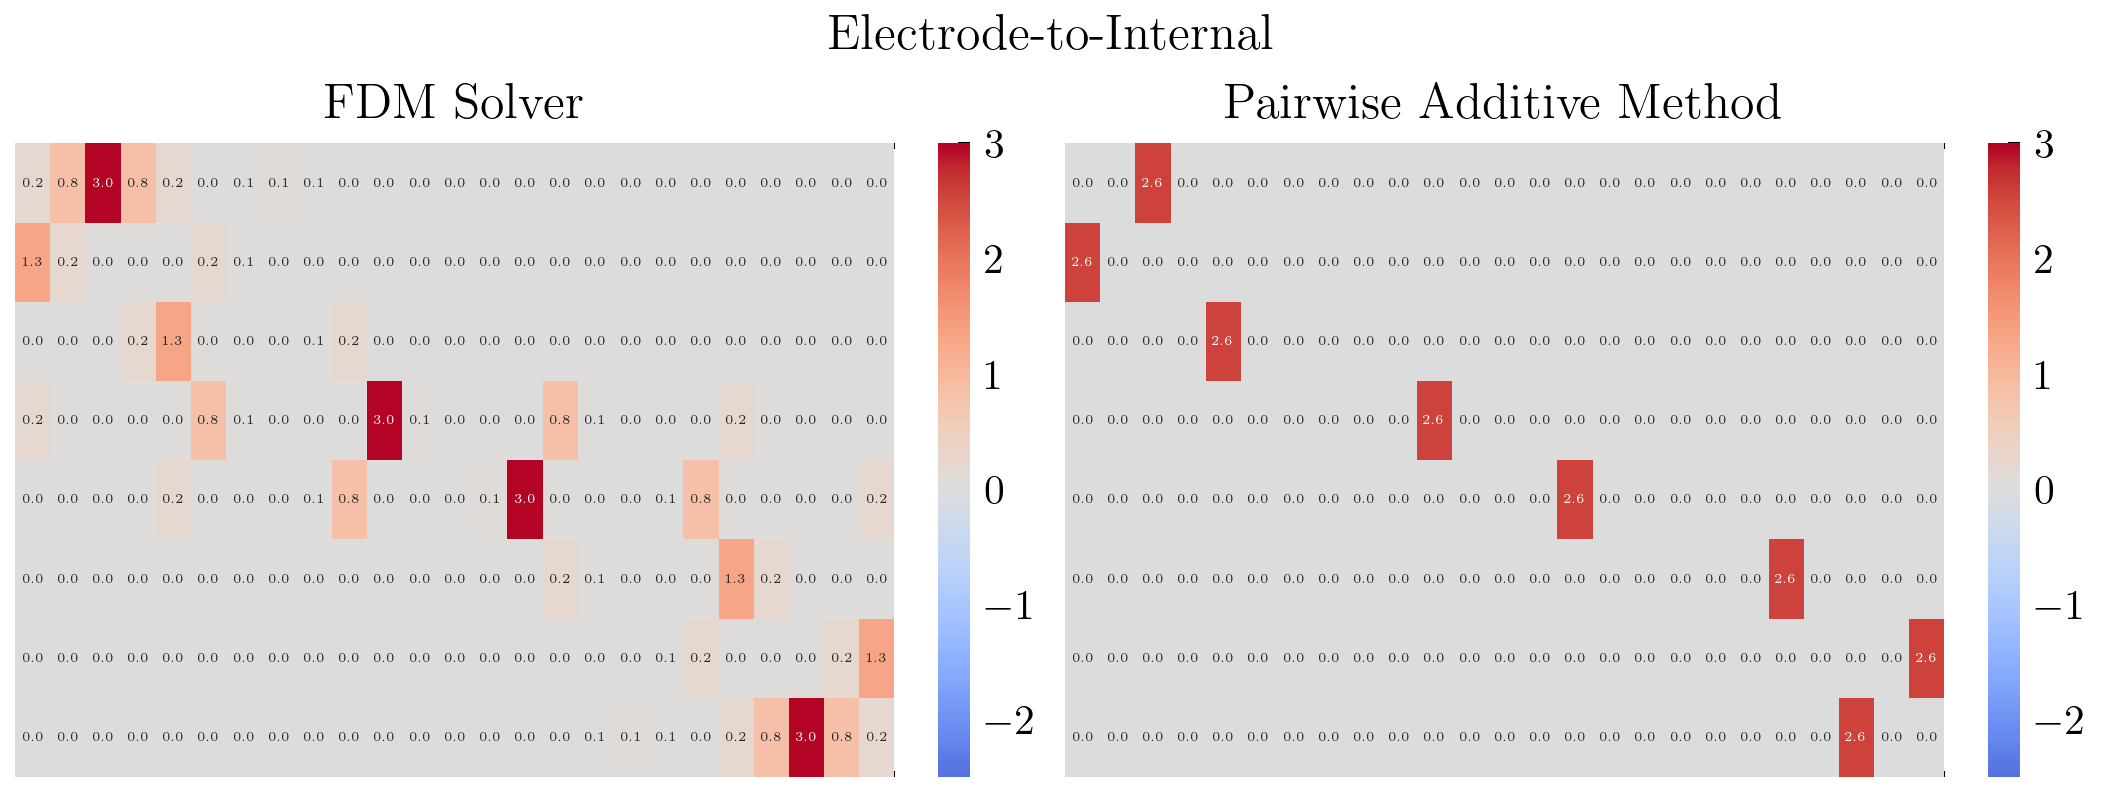

In [60]:
fig = plt.figure(dpi=300, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
fig.suptitle("Electrode-to-Internal")
ax  = fig.add_subplot(1,2,1)
ax  = sns.heatmap(np.abs(C_elec) * 1e18, ax=ax, cmap='coolwarm', center=0, annot=True, fmt=".1f", vmin=-2.5, vmax=3, annot_kws={"size":3})
_   = ax.set_xticklabels("")
_   = ax.set_yticklabels("")
_   = ax.set_title("FDM Solver")

ax  = fig.add_subplot(1,2,2)
ax  = sns.heatmap(get_simulation_based_matrices(5)[1], ax=ax, cmap='coolwarm', center=0, annot=True, fmt=".1f", vmin=-2.5, vmax=3, annot_kws={"size":3})
_   = ax.set_xticklabels("")
_   = ax.set_yticklabels("")
_   = ax.set_title("Pairwise Additive Method")

In [5]:
import numpy as np
import time
from numba import njit, prange

class FRWSolver:
    def __init__(self, pos_dict, radii_internal, electrode_radius=10.0):
        # Flatten dictionary to arrays
        self.keys = list(pos_dict.keys())
        self.n_total = len(self.keys)
        self.centers = np.zeros((self.n_total, 3), dtype=np.float64)
        self.radii = np.zeros(self.n_total, dtype=np.float64)
        self.is_internal = np.zeros(self.n_total, dtype=np.bool_)
        
        # Mapping
        self.key_to_idx = {k: i for i, k in enumerate(self.keys)}
        
        for i, k in enumerate(self.keys):
            r = radii_internal[k] if (k >= 0 and isinstance(radii_internal, (list, np.ndarray))) else (radii_internal if k>=0 else electrode_radius)
            self.centers[i, 0] = pos_dict[k][0]
            self.centers[i, 1] = pos_dict[k][1]
            self.centers[i, 2] = r # Sitting on surface
            self.radii[i] = r
            if k >= 0: self.is_internal[i] = True

    def run(self, n_walks=10000):
        print(f"Starting Raw-Count FRW for {self.n_total} conductors...")
        t0 = time.time()
        
        internal_indices = np.where(self.is_internal)[0]
        
        # Run Numba Core
        raw_counts = run_reflective_frw(
            self.centers, 
            self.radii, 
            internal_indices, 
            n_walks
        )
        
        dt = time.time() - t0
        print(f"Solved in {dt:.2f}s.")
        
        return self._format_results(raw_counts)

    def _format_results(self, raw_counts):
        """
        Returns raw hit counts.
        Rows = Target (Who was hit)
        Cols = Source (Where walker started)
        """
        int_keys = sorted([k for k in self.keys if k >= 0])
        elec_keys = sorted([k for k in self.keys if k < 0], reverse=True)
        
        n_int = len(int_keys)
        n_elec = len(elec_keys)
        
        # Initialize Matrices
        # C_internal: shape (N_nodes, N_nodes)
        C_internal = np.zeros((n_int, n_int), dtype=int)
        
        # C_electrode: shape (N_electrodes, N_nodes)
        C_electrode = np.zeros((n_elec, n_int), dtype=int)
        
        # Index of the 'Ground' column in raw_counts (last column)
        GND_IDX = self.n_total
        
        # Loop over Columns (Source Nodes)
        for col_idx, start_key in enumerate(int_keys):
            start_arr_idx = self.key_to_idx[start_key]
            
            # 1. Fill Diagonal with GROUND HITS
            # C[i,i] = Number of hits to Ground/Infinity starting from i
            ground_hits = raw_counts[start_arr_idx, GND_IDX]
            C_internal[col_idx, col_idx] = ground_hits
            
            # 2. Fill Off-Diagonals with NEIGHBOR HITS
            # C[j,i] = Number of hits to j starting from i
            for row_idx, target_key in enumerate(int_keys):
                if start_key == target_key: continue
                
                target_arr_idx = self.key_to_idx[target_key]
                hits = raw_counts[start_arr_idx, target_arr_idx]
                C_internal[row_idx, col_idx] = hits
                
            # 3. Fill Electrode Matrix with ELECTRODE HITS
            # C_elec[k, i] = Number of hits to Electrode k starting from i
            for row_idx, target_key in enumerate(elec_keys):
                target_arr_idx = self.key_to_idx[target_key]
                hits = raw_counts[start_arr_idx, target_arr_idx]
                C_electrode[row_idx, col_idx] = hits
                
        return C_internal, C_electrode

# ==========================================
# NUMBA KERNEL (Reflective)
# ==========================================
@njit(fastmath=True)
def get_nearest(x, y, z, centers, radii):
    min_dist = 1e9
    hit_idx = -1
    for i in range(centers.shape[0]):
        dx = x - centers[i, 0]
        dy = y - centers[i, 1]
        dz = z - centers[i, 2]
        d = np.sqrt(dx*dx + dy*dy + dz*dz) - radii[i]
        if d < min_dist:
            min_dist = d
            hit_idx = i
    return min_dist, hit_idx

@njit(parallel=True)
def run_reflective_frw(centers, radii, start_indices, n_walks):
    n_total = centers.shape[0]
    # Output: Cols 0..N-1 are conductors, Col N is GROUND
    counts = np.zeros((n_total, n_total + 1), dtype=np.int32)
    GND_IDX = n_total
    
    # SAFETY PARAMETERS
    TOL = 1e-4          # Hit detection distance (nm)
    LAUNCH = 1e-2       # Re-spawn distance (nm)
    MAX_STEPS = 10000   # Timeout limit
    
    # Dielectrics
    EPS_AIR, EPS_SIO2 = 1.0, 3.9
    P_cross = 2 * EPS_SIO2 / (EPS_AIR + EPS_SIO2)
    
    for i in prange(len(start_indices)):
        start_id = start_indices[i]
        c0, r0 = centers[start_id], radii[start_id]
        
        for _ in range(n_walks):
            # 1. Launch
            theta = np.random.uniform(0, 2*np.pi)
            phi = np.arccos(1 - 2*np.random.uniform(0, 1))
            
            dist_launch = r0 + LAUNCH
            x = c0[0] + dist_launch * np.sin(phi) * np.cos(theta)
            y = c0[1] + dist_launch * np.sin(phi) * np.sin(theta)
            z = c0[2] + dist_launch * np.cos(phi)
            
            eps = EPS_AIR
            steps = 0
            
            while steps < MAX_STEPS:
                steps += 1
                
                # A. Distances
                d_cond, hit_id = get_nearest(x, y, z, centers, radii)
                d_gnd = abs(z - (-35.0)) 
                d_int = abs(z)
                
                # B. Step Size 
                step = max(min(d_cond, d_gnd, d_int), 1e-6)
                
                # --- HIT CHECKS ---
                if d_cond < TOL:
                    if hit_id == start_id:
                        # REFLECT: Start sphere hit -> Bounce
                        theta = np.random.uniform(0, 2*np.pi)
                        phi = np.arccos(1 - 2*np.random.uniform(0, 1))
                        
                        x = c0[0] + dist_launch * np.sin(phi) * np.cos(theta)
                        y = c0[1] + dist_launch * np.sin(phi) * np.sin(theta)
                        z = c0[2] + dist_launch * np.cos(phi)
                        continue
                    else:
                        # TERMINATE: Hit Neighbor -> Record Hit
                        counts[start_id, hit_id] += 1
                        break
                
                if d_gnd < TOL:
                    # TERMINATE: Hit Ground -> Record Hit
                    counts[start_id, GND_IDX] += 1
                    break
                    
                # --- INTERFACE HANDLING ---
                if d_int < step + TOL and d_int < TOL:
                     prob = P_cross if eps == EPS_AIR else (2*EPS_AIR/(EPS_AIR+EPS_SIO2))
                     if np.random.random() < prob:
                         z = -z; eps = EPS_SIO2 if eps == EPS_AIR else EPS_AIR
                     z += np.sign(z) * LAUNCH
                     continue
                
                # --- MOVE ---
                theta = np.random.uniform(0, 2*np.pi)
                phi = np.arccos(1 - 2*np.random.uniform(0, 1))
                x += step * np.sin(phi) * np.cos(theta)
                y += step * np.sin(phi) * np.sin(theta)
                z += step * np.cos(phi)
                
                if x*x+y*y+z*z > 1e12: 
                    # Lost to infinity -> Count as Ground Hit
                    counts[start_id, GND_IDX] += 1
                    break
            
            # NOTE: If loop finishes because steps >= MAX_STEPS,
            # we simply fall out here. Nothing is incremented.
            # The walk is discarded (not counted in counts).
                    
    return counts

In [6]:
L = 3
topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*8}
simc = Simulation(topo)
pos_dict = simc.get_positions().copy()
radii = simc.get_radius().copy() # Your radius array

# 2. Initialize Solver
# Note: we treat electrodes as 10nm spheres too (as you suggested)
solver = FRWSolver(pos_dict, radii, electrode_radius=10.0)

# 3. Run (High n_walks for precision)
# This will run in parallel on all cores
C_int_prob, C_elec_prob = solver.run(n_walks=100_000)

print("Internal Matrix (Coupling Probabilities):")
print(np.round(C_int_prob, 4))

print("\nElectrode Matrix (Coupling Probabilities):")
print(np.round(C_elec_prob, 4))

Starting Raw-Count FRW for 17 conductors...
Solved in 79.43s.
Internal Matrix (Coupling Probabilities):
[[ 2262 13802   163 13115   972    94   132    73    52]
 [14261  1899 14297   912 13179   997    87    87    87]
 [  166 13604  2318    90   922 13319    47    74   125]
 [14354   943    88  1870 13304   111 14236   977    99]
 [ 1026 13210  1010 13250  1900 13213  1034 13395   985]
 [   74   974 14156   110 13286  1894    78   908 13984]
 [  140    97    40 13547   901    91  2289 13679   151]
 [   79   105    90   954 13390   931 14353  1880 14509]
 [   42    74   135    79  1018 13470   171 13499  2245]]

Electrode Matrix (Coupling Probabilities):
[[ 2558 13879  2569   141   166   115    48    51    58]
 [15262   185    71   988    95    32   121    52    28]
 [   75   202 15274    31    94  1029    37    44   100]
 [ 1032    74    33 13532   109    48  1067    90    42]
 [   36    90  1065    23   121 13347    50    89  1017]
 [  123    52    37  1018   115    27 14991   196    

In [35]:
C_ref       = 5.0
norm_factor = np.sum(C_int_prob, axis=1) + np.sum(C_elec_prob, axis=0)
c_mat       = (C_int_prob / norm_factor[:, None]) * C_ref
c_elec      = (C_elec_prob / norm_factor[None, :]) * C_ref

np.fill_diagonal(c_mat, np.sum(c_mat,axis=1)+np.sum(c_elec,axis=0))
np.round(c_mat,2)

array([[5.  , 1.38, 0.02, 1.32, 0.1 , 0.01, 0.01, 0.01, 0.01],
       [1.18, 5.  , 1.18, 0.08, 1.09, 0.08, 0.01, 0.01, 0.01],
       [0.02, 1.36, 5.  , 0.01, 0.09, 1.34, 0.  , 0.01, 0.01],
       [1.16, 0.08, 0.01, 5.  , 1.08, 0.01, 1.15, 0.08, 0.01],
       [0.09, 1.1 , 0.08, 1.1 , 5.  , 1.1 , 0.09, 1.12, 0.08],
       [0.01, 0.08, 1.16, 0.01, 1.09, 5.  , 0.01, 0.07, 1.14],
       [0.01, 0.01, 0.  , 1.36, 0.09, 0.01, 5.  , 1.37, 0.02],
       [0.01, 0.01, 0.01, 0.08, 1.1 , 0.08, 1.18, 5.  , 1.19],
       [0.  , 0.01, 0.01, 0.01, 0.1 , 1.35, 0.02, 1.35, 5.  ]])

In [26]:
C_ref = 5.0

c_mat = C_ref * C_int_prob / (np.sum(C_int_prob,axis=1)+np.sum(C_elec_prob,axis=0))
np.fill_diagonal(c_mat, np.sum(c_mat,axis=1))
np.round(c_mat,2)

array([[2.56, 1.14, 0.02, 1.06, 0.08, 0.01, 0.01, 0.01, 0.01],
       [1.43, 4.3 , 1.43, 0.07, 1.1 , 0.08, 0.01, 0.01, 0.01],
       [0.02, 1.13, 2.57, 0.01, 0.08, 1.09, 0.  , 0.01, 0.01],
       [1.44, 0.08, 0.01, 4.31, 1.11, 0.01, 1.43, 0.08, 0.01],
       [0.1 , 1.09, 0.1 , 1.07, 4.91, 1.08, 0.1 , 1.1 , 0.1 ],
       [0.01, 0.08, 1.42, 0.01, 1.11, 4.26, 0.01, 0.07, 1.4 ],
       [0.01, 0.01, 0.  , 1.09, 0.08, 0.01, 2.57, 1.12, 0.02],
       [0.01, 0.01, 0.01, 0.08, 1.12, 0.08, 1.44, 4.34, 1.45],
       [0.  , 0.01, 0.01, 0.01, 0.08, 1.1 , 0.02, 1.11, 2.56]])

In [27]:
C_ref * C_elec_prob / (np.sum(C_int_prob,axis=1)+np.sum(C_elec_prob,axis=0))

array([[0.25668299, 1.14899993, 0.25754386, 0.01139449, 0.01383426,
        0.00939988, 0.00481261, 0.00417731, 0.00580522],
       [1.53146825, 0.01531558, 0.00711779, 0.07984225, 0.00791719,
        0.00261562, 0.01213179, 0.00425922, 0.00280252],
       [0.00752589, 0.01672296, 1.53122807, 0.00250517, 0.00783386,
        0.08410848, 0.00370972, 0.00360396, 0.01000901],
       [0.10355623, 0.00612623, 0.00330827, 1.09354797, 0.00908394,
        0.00392343, 0.10698029, 0.00737173, 0.00420378],
       [0.00361243, 0.00745082, 0.10676692, 0.00185868, 0.01008401,
        1.09095813, 0.00501313, 0.00728982, 0.10179161],
       [0.01234246, 0.00430492, 0.00370927, 0.08226661, 0.00958397,
        0.00220693, 1.50303796, 0.01605399, 0.0060054 ],
       [0.00230794, 0.00471886, 0.01132832, 0.00234355, 0.00975065,
        0.08010332, 0.00701839, 0.01539873, 1.52957662],
       [0.00541864, 0.00422213, 0.00481203, 0.01034394, 0.01300087,
        0.01054421, 0.25566986, 1.1502359 , 0.26373736]])

In [4]:
# ==========================================
# POST-PROCESSING: Convert to Farads
# ==========================================

# 1. Physics Constants
eps_0 = 8.854e-12 
R_sphere = 10e-9 
eps_avg = (1.0 + 3.9) / 2 # Air/SiO2 average

# 2. Scaling Factor (Analytical Estimate)
# We add a 30% enhancement factor (1.3) for the substrate proximity
C_total_approx = 1.3 * (4 * np.pi * eps_0 * eps_avg * R_sphere)
print(f"Scaling Factor (C_total): {C_total_approx * 1e18:.2f} aF")

# 3. Create Final Matrices (Farads)
# Your output "C_int_prob" is the P matrix
C_internal_Farads = np.zeros_like(C_int_prob)
C_electrode_Farads = np.zeros_like(C_elec_prob)

# --- A. Off-Diagonals (Mutuals) ---
# C_ij = -1 * P_ij * C_total (Maxwell Form)
# Or just P_ij * C_total (Physical Magnitude)
# Let's compute Physical Magnitude (Positive)
C_internal_Farads = C_int_prob * C_total_approx
C_electrode_Farads = C_elec_prob * C_total_approx

# --- B. Diagonals (Self) ---
# For Maxwell Matrix, Diagonal = Sum of all Flux leaving = C_total
# We overwrite the diagonal (which was 0 in probabilities)
np.fill_diagonal(C_internal_Farads, C_total_approx)

# 4. Display
print("\n--- Final Internal Matrix (aF) ---")
# Rows = Source, Cols = Target
print(np.round(C_internal_Farads * 1e18, 2))

print("\n--- Final Electrode Matrix (aF) ---")
print(np.round(C_electrode_Farads * 1e18, 2))

Scaling Factor (C_total): 3.54 aF

--- Final Internal Matrix (aF) ---
[[3.54 0.48 0.01 0.47 0.03 0.   0.   0.   0.  ]
 [0.52 3.54 0.51 0.03 0.47 0.03 0.   0.   0.  ]
 [0.01 0.48 3.54 0.   0.03 0.48 0.   0.   0.  ]
 [0.5  0.03 0.   3.54 0.47 0.   0.5  0.03 0.  ]
 [0.04 0.47 0.04 0.47 3.54 0.47 0.04 0.47 0.04]
 [0.   0.03 0.51 0.   0.47 3.54 0.   0.04 0.5 ]
 [0.   0.   0.   0.48 0.03 0.   3.54 0.49 0.01]
 [0.   0.   0.   0.03 0.47 0.03 0.51 3.54 0.51]
 [0.   0.   0.   0.   0.03 0.47 0.01 0.48 3.54]]

--- Final Electrode Matrix (aF) ---
[[0.09 0.49 0.09 0.01 0.01 0.   0.   0.   0.  ]
 [0.54 0.01 0.   0.03 0.   0.   0.   0.   0.  ]
 [0.   0.01 0.53 0.   0.   0.04 0.   0.   0.  ]
 [0.04 0.   0.   0.48 0.01 0.   0.04 0.   0.  ]
 [0.   0.   0.04 0.   0.   0.47 0.   0.   0.04]
 [0.   0.   0.   0.04 0.   0.   0.54 0.01 0.  ]
 [0.   0.   0.   0.   0.   0.04 0.   0.01 0.54]
 [0.   0.   0.   0.   0.01 0.   0.09 0.5  0.09]]


In [3]:
fig = plt.figure(dpi=300, layout='constrained')
ax  = fig.add_subplot()
ax  = sns.heatmap(C_int_prob, ax=ax, cmap='coolwarm', center=0, annot=False, fmt=".1f")#, vmin=-2.5, vmax=10)
_   = ax.set_title("FRM")
_   = ax.set_xticklabels("")
_   = ax.set_yticklabels("")

NameError: name 'plt' is not defined

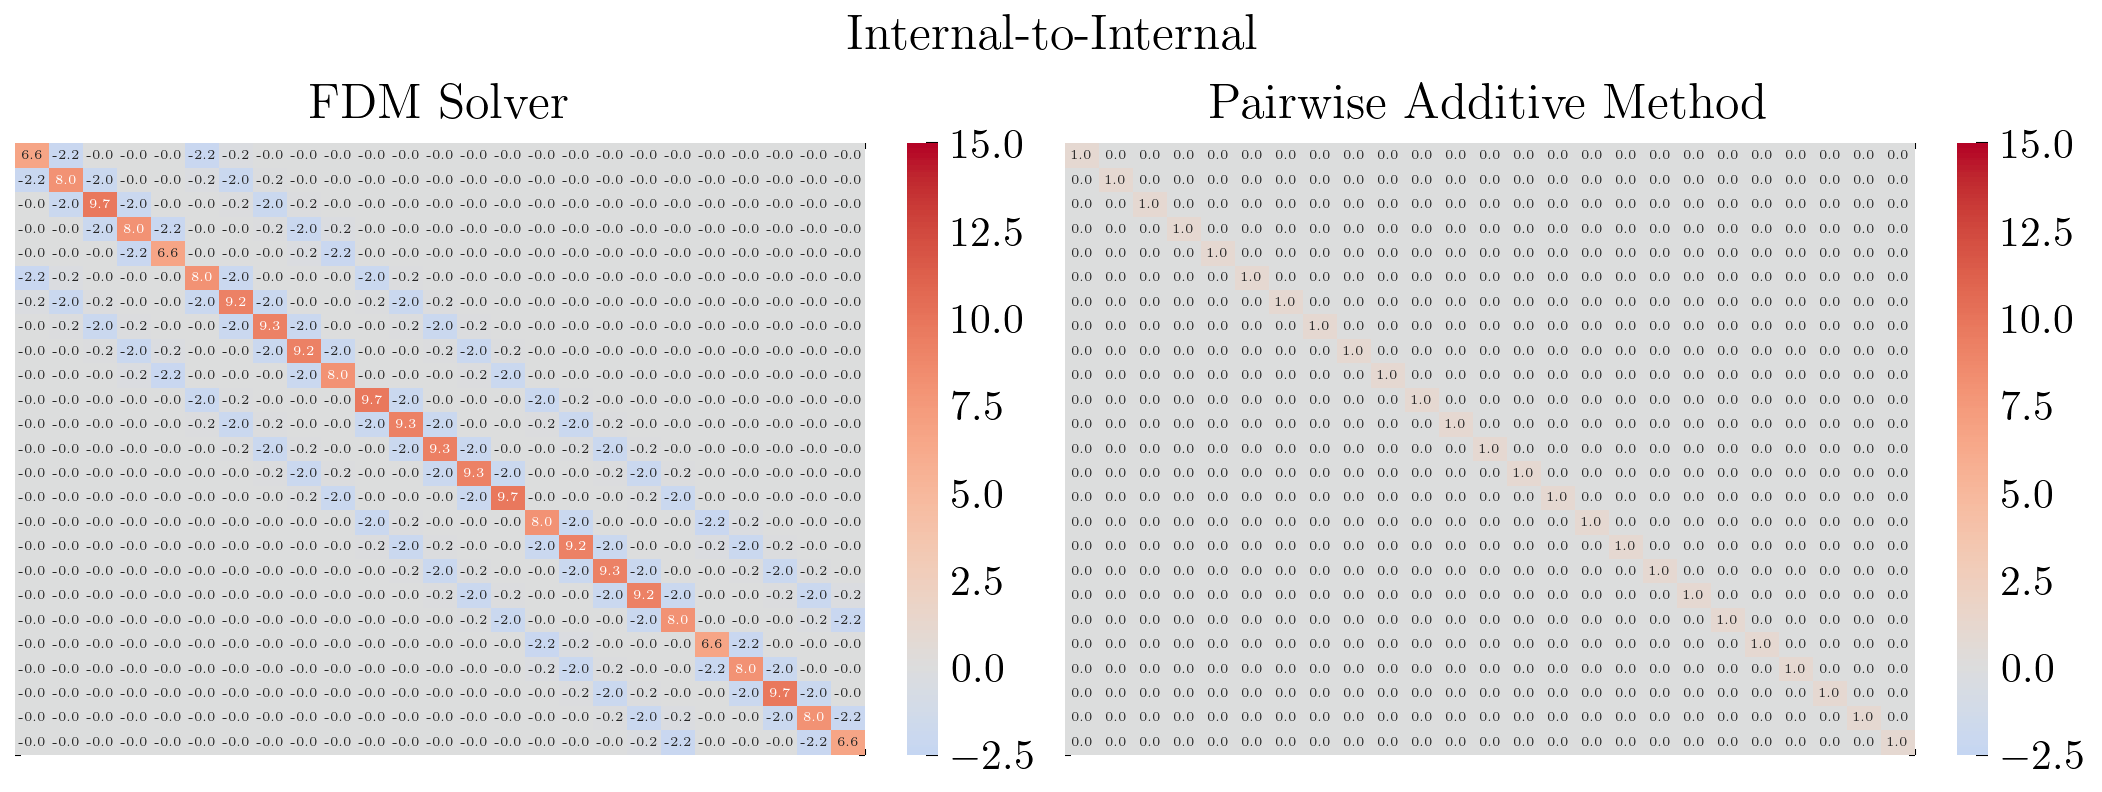

In [104]:
fig = plt.figure(dpi=300, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
fig.suptitle("Internal-to-Internal")
ax  = fig.add_subplot(1,2,1)
ax  = sns.heatmap(C_sph * 1e18, ax=ax, cmap='coolwarm', center=0, annot=True, fmt=".1f", vmin=-2.5, vmax=15, annot_kws={"size":3})#, vmin=-2.5, vmax=10)
_   = ax.set_title("FDM Solver")
_   = ax.set_xticklabels("")
_   = ax.set_yticklabels("")

ax  = fig.add_subplot(1,2,2)
ax  = sns.heatmap(C_int_prob, ax=ax, cmap='coolwarm', center=0, annot=True, fmt=".1f", vmin=-2.5, vmax=15, annot_kws={"size":3})#, vmin=-2.5, vmax=10)
_   = ax.set_title("Pairwise Additive Method")
_   = ax.set_xticklabels("")
_   = ax.set_yticklabels("")